# k-Nearest-Neighbors: kNN-regressor

## loading data and data exploration

In [1]:
import tensorflow.keras as ks
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import load_diabetes
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor

2023-07-01 21:14:36.716369: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-01 21:14:36.774255: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-01 21:14:36.774952: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-01 21:14:37.869309: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Load data from scikit_learn
diabetes_dict = load_diabetes()
# Construct DataFrame with features data, Data is already normalized according to documentation
data = pd.DataFrame(diabetes_dict['data'], columns=diabetes_dict['feature_names'])
# Scaler target data to scale [0, 1]
scaler = MinMaxScaler()
targets_scaled = scaler.fit_transform(diabetes_dict['target'][:, np.newaxis])
# Construct DataFrame with target data
data_target = pd.DataFrame(targets_scaled, columns=['target'])

# Explore whether there are missing values among the features, Result: no
print(f'Are any missing values in feature data set? \nAnswer:\t{data.isna().any().any()}\n\
Are any missing values in target data set?\nAnswer:\t{data_target.isna().any().any()}')
# Explore if there are irrelevant features by calculating Pearson-correlation with target
pd.concat([data, data_target], axis=1).corr()

# Define useful function
def rmse(a, b):
    '''Function returns rmse for two array-like objects (must have same length)'''
    return np.sqrt(np.sum(np.square(a - b))/len(a))

Are any missing values in feature data set? 
Answer:	False
Are any missing values in target data set?
Answer:	False


In [3]:
# sex has correlation close to zero with target. Thus it is excluded from regression.
data.drop('sex', axis='columns', inplace=True)

In [4]:
# Are there any similar features? (check for co-linearity)
print(data.corr()[data.corr()>0.5])
# A correlation of >0.7 occur between s1 and s2. s2 is chosen for dropping because it also shwos 2. highest
# observed correlation among all correlation (with s3)
data.drop('s2', axis='columns', inplace=True)

     age  bmi   bp        s1        s2   s3        s4        s5   s6
age  1.0  NaN  NaN       NaN       NaN  NaN       NaN       NaN  NaN
bmi  NaN  1.0  NaN       NaN       NaN  NaN       NaN       NaN  NaN
bp   NaN  NaN  1.0       NaN       NaN  NaN       NaN       NaN  NaN
s1   NaN  NaN  NaN  1.000000  0.896663  NaN  0.542207  0.515503  NaN
s2   NaN  NaN  NaN  0.896663  1.000000  NaN  0.659817       NaN  NaN
s3   NaN  NaN  NaN       NaN       NaN  1.0       NaN       NaN  NaN
s4   NaN  NaN  NaN  0.542207  0.659817  NaN  1.000000  0.617859  NaN
s5   NaN  NaN  NaN  0.515503       NaN  NaN  0.617859  1.000000  NaN
s6   NaN  NaN  NaN       NaN       NaN  NaN       NaN       NaN  1.0


## Apply kNN-regressor to problem

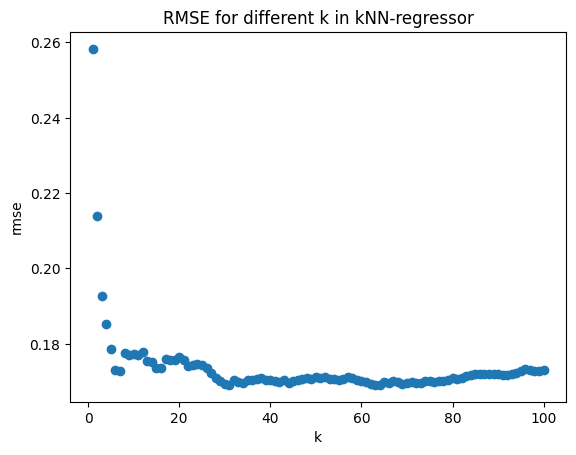

In [12]:
def knn_regressor_k(X_train, X_test, y_train, y_test, k=40):
    # loop over possible values for number of neighrest neighbors
    # list to collect rmse in
    rmse_k = []
    for k_ in range(1, k+1):
        # Initiate kNNRegressor instance
        knn = KNeighborsRegressor(n_neighbors=k_)
        # Fit regressor to 
        knn.fit(X=X_train, y=y_train)
        # Predict on test data and calculate rmse form result
        rmse_k.append([k_, rmse(knn.predict(X_test).flatten(), y_test.to_numpy().flatten())])
    return pd.DataFrame(rmse_k, columns=['k', 'rmse'])


# Generate train, test split with default 75 % training data
X_train, X_test, y_train, y_test = train_test_split(data, data_target, random_state=25)
# calculate kNN-Regressor
rmse_result = knn_regressor_k(X_train, X_test, y_train, y_test, k=100)
# Plot result
fig, ax = plt.subplots()
ax.set_xlabel('k')
ax.set_ylabel('rmse')
ax.set_title('RMSE for different k in kNN-regressor')
ax.scatter(rmse_result.k, rmse_result.rmse)
plt.show()

Choosing appropriate k can achieve rmse in the range of 0.16 to 0.18 depending on train/test-split

In [34]:
# k=30 seems a reasonable choice. Calculate distribution of rmse for batch of different choices of
# train/test_split

def kNN_regressor_over_batch(data, data_target, n=100, k=30):
    # list to store rmse of each iteration
    rmse_list = []
    for i in range(n):
        # Generate train, test split with default 75 % training data
        X_train, X_test, y_train, y_test = train_test_split(data, data_target)
        # Initiate kNNRegressor instance
        knn_ = KNeighborsRegressor(n_neighbors=k)
        # Fit regressor to 
        knn_.fit(X=X_train, y=y_train)
        # Predict on test data and calculate rmse form result
        rmse_list.append(rmse(knn_.predict(X_test).flatten(), y_test.to_numpy().flatten()))
    return pd.DataFrame(rmse_list, columns=['rmse'])

rmse_k10 = kNN_regressor_over_batch(data, data_target, k=30)
print(f'Mean of rmse of kNN-regressor using different train/test batches: {rmse_k10.rmse.mean():.1f}\
 +/- {rmse_k10.rmse.std():.2f}')

Mean of rmse of kNN-regressor using different train/test batches: 0.2 +/- 0.01


## Using PCA to reduce dimensionality befor fitting

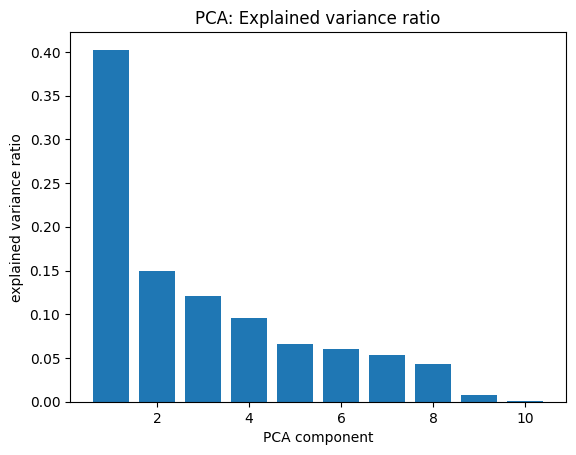

In [29]:
# reload feature data set
data = pd.DataFrame(diabetes_dict['data'], columns=diabetes_dict['feature_names'])
# Perform PCA on feature data set, keep number of dimensions and explore explained variance
pca_features = PCA()
pca_features.fit(data)
# Store and plot explained variance ratio for all 10 transformed components
expl_variance = pca_features.explained_variance_ratio_
fig, ax = plt.subplots()
ax.bar(x=range(1, len(expl_variance)+1), height=expl_variance)
ax.set_xlabel('PCA component')
ax.set_ylabel('explained variance ratio')
ax.set_title('PCA: Explained variance ratio')
# As from these results, first 8 components are chosen for further investigation
pca_features = PCA(n_components=8)
pca8_data = pca_features.fit_transform(data)

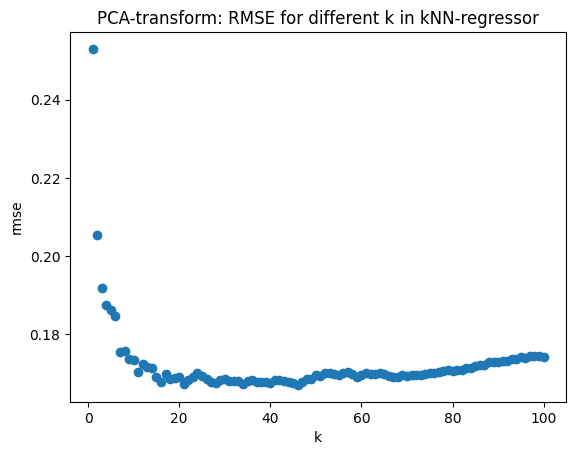

In [33]:
# Train and test kNN-Regressor on PCA-transformed data for different k

# Generate train, test split with default 75 % training data
X_train, X_test, y_train, y_test = train_test_split(data, data_target, random_state=25)
pca_rmse_result = knn_regressor_k(X_train, X_test, y_train, y_test, k=100)
# Plot result
fig, ax = plt.subplots()
ax.set_xlabel('k')
ax.set_ylabel('rmse')
ax.set_title('PCA-transform: RMSE for different k in kNN-regressor')
ax.scatter(pca_rmse_result.k, pca_rmse_result.rmse)
plt.show()

In [38]:
# k=30 still seems reasonable
# Calcu
pca_rmse_k10 = kNN_regressor_over_batch(pca8_data, data_target, n=100, k=30)

print(f'PCA-transformed data: Mean of rmse of kNN-regressor using different train/test batches\
: {pca_rmse_k10.rmse.mean():.1f} +/- {pca_rmse_k10.rmse.std():.2f}')

PCA-transformed data: Mean of rmse of kNN-regressor using different train/test batches: 0.2 +/- 0.01


Approach of dimensionality reduction through PCA results in comparable prediction results.

# Neuronal network predictor for comparisson

In [9]:
# reload feature data set
data = pd.DataFrame(diabetes_dict['data'], columns=diabetes_dict['feature_names'])
# Drop same columns as in kNN-regressor attempt for same reasons.
data.drop('sex', axis='columns', inplace=True)
data.drop('s2', axis='columns', inplace=True)
# target data was already loaded and scaled. No need to do again

# Define neuronal network
diabetes_net = ks.Sequential()
diabetes_net.add(ks.layers.Dense(8, activation='tanh', input_shape=(8,))) # 1. Hidden layer
diabetes_net.add(ks.layers.Dense(1, activation='linear'))# Output layer
diabetes_net.compile(optimizer='adam', metrics='RootMeanSquaredError', 
                     loss='mean_squared_error')

# Set up train/test_split
X_train, X_test, y_train, y_test = train_test_split(data, data_target, random_state=100)
# Set up list to store loss during fit (per epoch)
history_list = []

In [10]:
# Fit neuronal network to training data set
history = diabetes_net.fit(X_train, y_train, batch_size=32, epochs=100)
# extract loss from history-object
history_list += history.history['loss']

Epoch 1/100
11/11 [==============================] - 1s 2ms/step - loss: 0.2240 - root_mean_squared_error: 0.4733
Epoch 2/100
11/11 [==============================] - 0s 3ms/step - loss: 0.1891 - root_mean_squared_error: 0.4349
Epoch 3/100
11/11 [==============================] - 0s 3ms/step - loss: 0.1583 - root_mean_squared_error: 0.3978
Epoch 4/100
11/11 [==============================] - 0s 3ms/step - loss: 0.1319 - root_mean_squared_error: 0.3632
Epoch 5/100
11/11 [==============================] - 0s 3ms/step - loss: 0.1093 - root_mean_squared_error: 0.3306
Epoch 6/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0921 - root_mean_squared_error: 0.3035
Epoch 7/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0774 - root_mean_squared_error: 0.2782
Epoch 8/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0669 - root_mean_squared_error: 0.2587
Epoch 9/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0595 - root_m

11/11 [==============================] - 0s 2ms/step - loss: 0.0301 - root_mean_squared_error: 0.1736
Epoch 73/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0302 - root_mean_squared_error: 0.1738
Epoch 74/100
11/11 [==============================] - 0s 2ms/step - loss: 0.0300 - root_mean_squared_error: 0.1733
Epoch 75/100
11/11 [==============================] - 0s 2ms/step - loss: 0.0300 - root_mean_squared_error: 0.1733
Epoch 76/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0300 - root_mean_squared_error: 0.1733
Epoch 77/100
11/11 [==============================] - 0s 2ms/step - loss: 0.0300 - root_mean_squared_error: 0.1733
Epoch 78/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0300 - root_mean_squared_error: 0.1731
Epoch 79/100
11/11 [==============================] - 0s 2ms/step - loss: 0.0300 - root_mean_squared_error: 0.1732
Epoch 80/100
11/11 [==============================] - 0s 2ms/step - loss: 0.0299 - root_mean_

Smallest loss during training:	0.030
4/4 [==============================] - 0s 2ms/step
RMSE on test data set is:	0.16


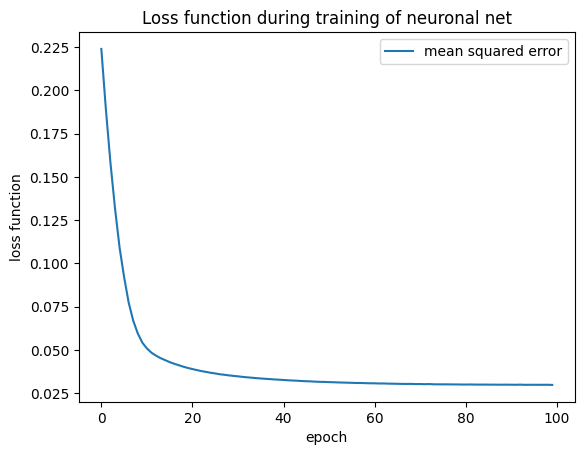

In [13]:
# Print smallest loss in training (handy to evaluate nets with different hyperparameters)
print(f'Smallest loss during training:\t{min(history_list):.3f}')
# Make prediction on test-dataset
net_predictions = diabetes_net.predict(X_test)
# Calculate rmse on predictions on test data set
net_rmse = rmse(net_predictions.flatten(), y_test.to_numpy().flatten())
print(f'RMSE on test data set is:\t{net_rmse:.2f}')

# Plot loss-function
fig, ax = plt.subplots()
ax.plot(history_list, label='mean squared error')
ax.set_xlabel('epoch')
ax.set_ylabel('loss function')
ax.set_title('Loss function during training of neuronal net')
ax.legend()

In [10]:
# As neuronal net seems able to obtain smaller RMSE on test data set, statistic for different 
# train/test-splits is calculated

# reload feature data set
data = pd.DataFrame(diabetes_dict['data'], columns=diabetes_dict['feature_names'])
# Drop same columns as in kNN-regressor attempt for same reasons.
data.drop('sex', axis='columns', inplace=True)
data.drop('s2', axis='columns', inplace=True)
# List to store achieved rmse in

net_rmse_list = []

In [20]:
# Loop over different train/tets.splits and fit new neuronal net every time
for i in range(5):
    # Set up train/test_split
    X_train, X_test, y_train, y_test = train_test_split(data, data_target, random_state=i**2)
    # Define neuronal network
    net = ks.Sequential()
    net.add(ks.layers.Dense(8, activation='tanh', input_shape=(8,))) # 1. Hidden layer
    net.add(ks.layers.Dense(1, activation='linear'))# Output layer
    net.compile(optimizer='adam', metrics='RootMeanSquaredError', 
                     loss='mean_squared_error')
    # Fit neuronal network to training data set
    net.fit(X_train, y_train, batch_size=32, epochs=100)
    # Evaluate predictions on test data set
    net_rmse_list.append(rmse(net.predict(X_test).flatten(), y_test.to_numpy().flatten()))

Epoch 1/100
11/11 [==============================] - 1s 3ms/step - loss: 0.1979 - root_mean_squared_error: 0.4449
Epoch 2/100
11/11 [==============================] - 0s 4ms/step - loss: 0.1665 - root_mean_squared_error: 0.4081
Epoch 3/100
11/11 [==============================] - 0s 3ms/step - loss: 0.1390 - root_mean_squared_error: 0.3728
Epoch 4/100
11/11 [==============================] - 0s 3ms/step - loss: 0.1144 - root_mean_squared_error: 0.3382
Epoch 5/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0943 - root_mean_squared_error: 0.3071
Epoch 6/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0774 - root_mean_squared_error: 0.2782
Epoch 7/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0645 - root_mean_squared_error: 0.2540
Epoch 8/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0550 - root_mean_squared_error: 0.2346
Epoch 9/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0490 - root_m

11/11 [==============================] - 0s 3ms/step - loss: 0.0290 - root_mean_squared_error: 0.1703
Epoch 73/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0288 - root_mean_squared_error: 0.1698
Epoch 74/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0289 - root_mean_squared_error: 0.1699
Epoch 75/100
11/11 [==============================] - 0s 2ms/step - loss: 0.0288 - root_mean_squared_error: 0.1696
Epoch 76/100
11/11 [==============================] - 0s 2ms/step - loss: 0.0287 - root_mean_squared_error: 0.1694
Epoch 77/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0287 - root_mean_squared_error: 0.1693
Epoch 78/100
11/11 [==============================] - 0s 2ms/step - loss: 0.0286 - root_mean_squared_error: 0.1691
Epoch 79/100
11/11 [==============================] - 0s 2ms/step - loss: 0.0286 - root_mean_squared_error: 0.1692
Epoch 80/100
11/11 [==============================] - 0s 2ms/step - loss: 0.0286 - root_mean_

Epoch 43/100
11/11 [==============================] - 0s 2ms/step - loss: 0.0299 - root_mean_squared_error: 0.1730
Epoch 44/100
11/11 [==============================] - 0s 2ms/step - loss: 0.0299 - root_mean_squared_error: 0.1729
Epoch 45/100
11/11 [==============================] - 0s 2ms/step - loss: 0.0299 - root_mean_squared_error: 0.1728
Epoch 46/100
11/11 [==============================] - 0s 2ms/step - loss: 0.0299 - root_mean_squared_error: 0.1728
Epoch 47/100
11/11 [==============================] - 0s 2ms/step - loss: 0.0297 - root_mean_squared_error: 0.1724
Epoch 48/100
11/11 [==============================] - 0s 2ms/step - loss: 0.0297 - root_mean_squared_error: 0.1723
Epoch 49/100
11/11 [==============================] - 0s 2ms/step - loss: 0.0296 - root_mean_squared_error: 0.1721
Epoch 50/100
11/11 [==============================] - 0s 2ms/step - loss: 0.0296 - root_mean_squared_error: 0.1720
Epoch 51/100
11/11 [==============================] - 0s 2ms/step - loss: 0.0295

11/11 [==============================] - 0s 2ms/step - loss: 0.0633 - root_mean_squared_error: 0.2516
Epoch 14/100
11/11 [==============================] - 0s 2ms/step - loss: 0.0608 - root_mean_squared_error: 0.2465
Epoch 15/100
11/11 [==============================] - 0s 2ms/step - loss: 0.0586 - root_mean_squared_error: 0.2421
Epoch 16/100
11/11 [==============================] - 0s 2ms/step - loss: 0.0566 - root_mean_squared_error: 0.2379
Epoch 17/100
11/11 [==============================] - 0s 2ms/step - loss: 0.0548 - root_mean_squared_error: 0.2342
Epoch 18/100
11/11 [==============================] - 0s 2ms/step - loss: 0.0532 - root_mean_squared_error: 0.2306
Epoch 19/100
11/11 [==============================] - 0s 2ms/step - loss: 0.0517 - root_mean_squared_error: 0.2273
Epoch 20/100
11/11 [==============================] - 0s 2ms/step - loss: 0.0504 - root_mean_squared_error: 0.2244
Epoch 21/100
11/11 [==============================] - 0s 2ms/step - loss: 0.0491 - root_mean_

11/11 [==============================] - 0s 2ms/step - loss: 0.0308 - root_mean_squared_error: 0.1756
Epoch 85/100
11/11 [==============================] - 0s 2ms/step - loss: 0.0308 - root_mean_squared_error: 0.1756
Epoch 86/100
11/11 [==============================] - 0s 2ms/step - loss: 0.0307 - root_mean_squared_error: 0.1753
Epoch 87/100
11/11 [==============================] - 0s 2ms/step - loss: 0.0306 - root_mean_squared_error: 0.1751
Epoch 88/100
11/11 [==============================] - 0s 2ms/step - loss: 0.0307 - root_mean_squared_error: 0.1753
Epoch 89/100
11/11 [==============================] - 0s 2ms/step - loss: 0.0306 - root_mean_squared_error: 0.1748
Epoch 90/100
11/11 [==============================] - 0s 2ms/step - loss: 0.0305 - root_mean_squared_error: 0.1747
Epoch 91/100
11/11 [==============================] - 0s 2ms/step - loss: 0.0305 - root_mean_squared_error: 0.1745
Epoch 92/100
11/11 [==============================] - 0s 2ms/step - loss: 0.0305 - root_mean_

Epoch 55/100
11/11 [==============================] - 0s 2ms/step - loss: 0.0311 - root_mean_squared_error: 0.1765
Epoch 56/100
11/11 [==============================] - 0s 2ms/step - loss: 0.0311 - root_mean_squared_error: 0.1764
Epoch 57/100
11/11 [==============================] - 0s 2ms/step - loss: 0.0311 - root_mean_squared_error: 0.1764
Epoch 58/100
11/11 [==============================] - 0s 2ms/step - loss: 0.0311 - root_mean_squared_error: 0.1763
Epoch 59/100
11/11 [==============================] - 0s 2ms/step - loss: 0.0311 - root_mean_squared_error: 0.1763
Epoch 60/100
11/11 [==============================] - 0s 2ms/step - loss: 0.0311 - root_mean_squared_error: 0.1763
Epoch 61/100
11/11 [==============================] - 0s 2ms/step - loss: 0.0311 - root_mean_squared_error: 0.1763
Epoch 62/100
11/11 [==============================] - 0s 2ms/step - loss: 0.0311 - root_mean_squared_error: 0.1762
Epoch 63/100
11/11 [==============================] - 0s 2ms/step - loss: 0.0310

11/11 [==============================] - 0s 2ms/step - loss: 0.0332 - root_mean_squared_error: 0.1823
Epoch 26/100
11/11 [==============================] - 0s 2ms/step - loss: 0.0331 - root_mean_squared_error: 0.1818
Epoch 27/100
11/11 [==============================] - 0s 2ms/step - loss: 0.0329 - root_mean_squared_error: 0.1814
Epoch 28/100
11/11 [==============================] - 0s 2ms/step - loss: 0.0327 - root_mean_squared_error: 0.1809
Epoch 29/100
11/11 [==============================] - 0s 2ms/step - loss: 0.0326 - root_mean_squared_error: 0.1806
Epoch 30/100
11/11 [==============================] - 0s 2ms/step - loss: 0.0325 - root_mean_squared_error: 0.1802
Epoch 31/100
11/11 [==============================] - 0s 2ms/step - loss: 0.0324 - root_mean_squared_error: 0.1799
Epoch 32/100
11/11 [==============================] - 0s 2ms/step - loss: 0.0322 - root_mean_squared_error: 0.1795
Epoch 33/100
11/11 [==============================] - 0s 2ms/step - loss: 0.0321 - root_mean_

11/11 [==============================] - 0s 2ms/step - loss: 0.0296 - root_mean_squared_error: 0.1720
Epoch 97/100
11/11 [==============================] - 0s 2ms/step - loss: 0.0296 - root_mean_squared_error: 0.1720
Epoch 98/100
11/11 [==============================] - 0s 2ms/step - loss: 0.0296 - root_mean_squared_error: 0.1721
Epoch 99/100
11/11 [==============================] - 0s 2ms/step - loss: 0.0296 - root_mean_squared_error: 0.1720
Epoch 100/100
4/4 [==============================] - 0s 1ms/step


In [21]:
# Print basic statistics for performence of neuronal net on test/split-sets
net_rmse = pd.DataFrame(net_rmse_list, columns=['rmse'])
print(f'Neuronal network achieves on different training/test-splits mean\
#RMSE of: {net_rmse.rmse.mean():.2f} +/- {net_rmse.rmse.std():.3f}')

Neuronal network achieves on different training/test-splits mean#RMSE of: 0.17 +/- 0.009


Conclusively it can be said, that the neuronal net performed a little better on test data set (typical RMSE of 0.17 compared to 0.2 for kNN) with comarable absolute standard deviation (about 0.01 in both cases).